In [2]:
import tensorflow as tf

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


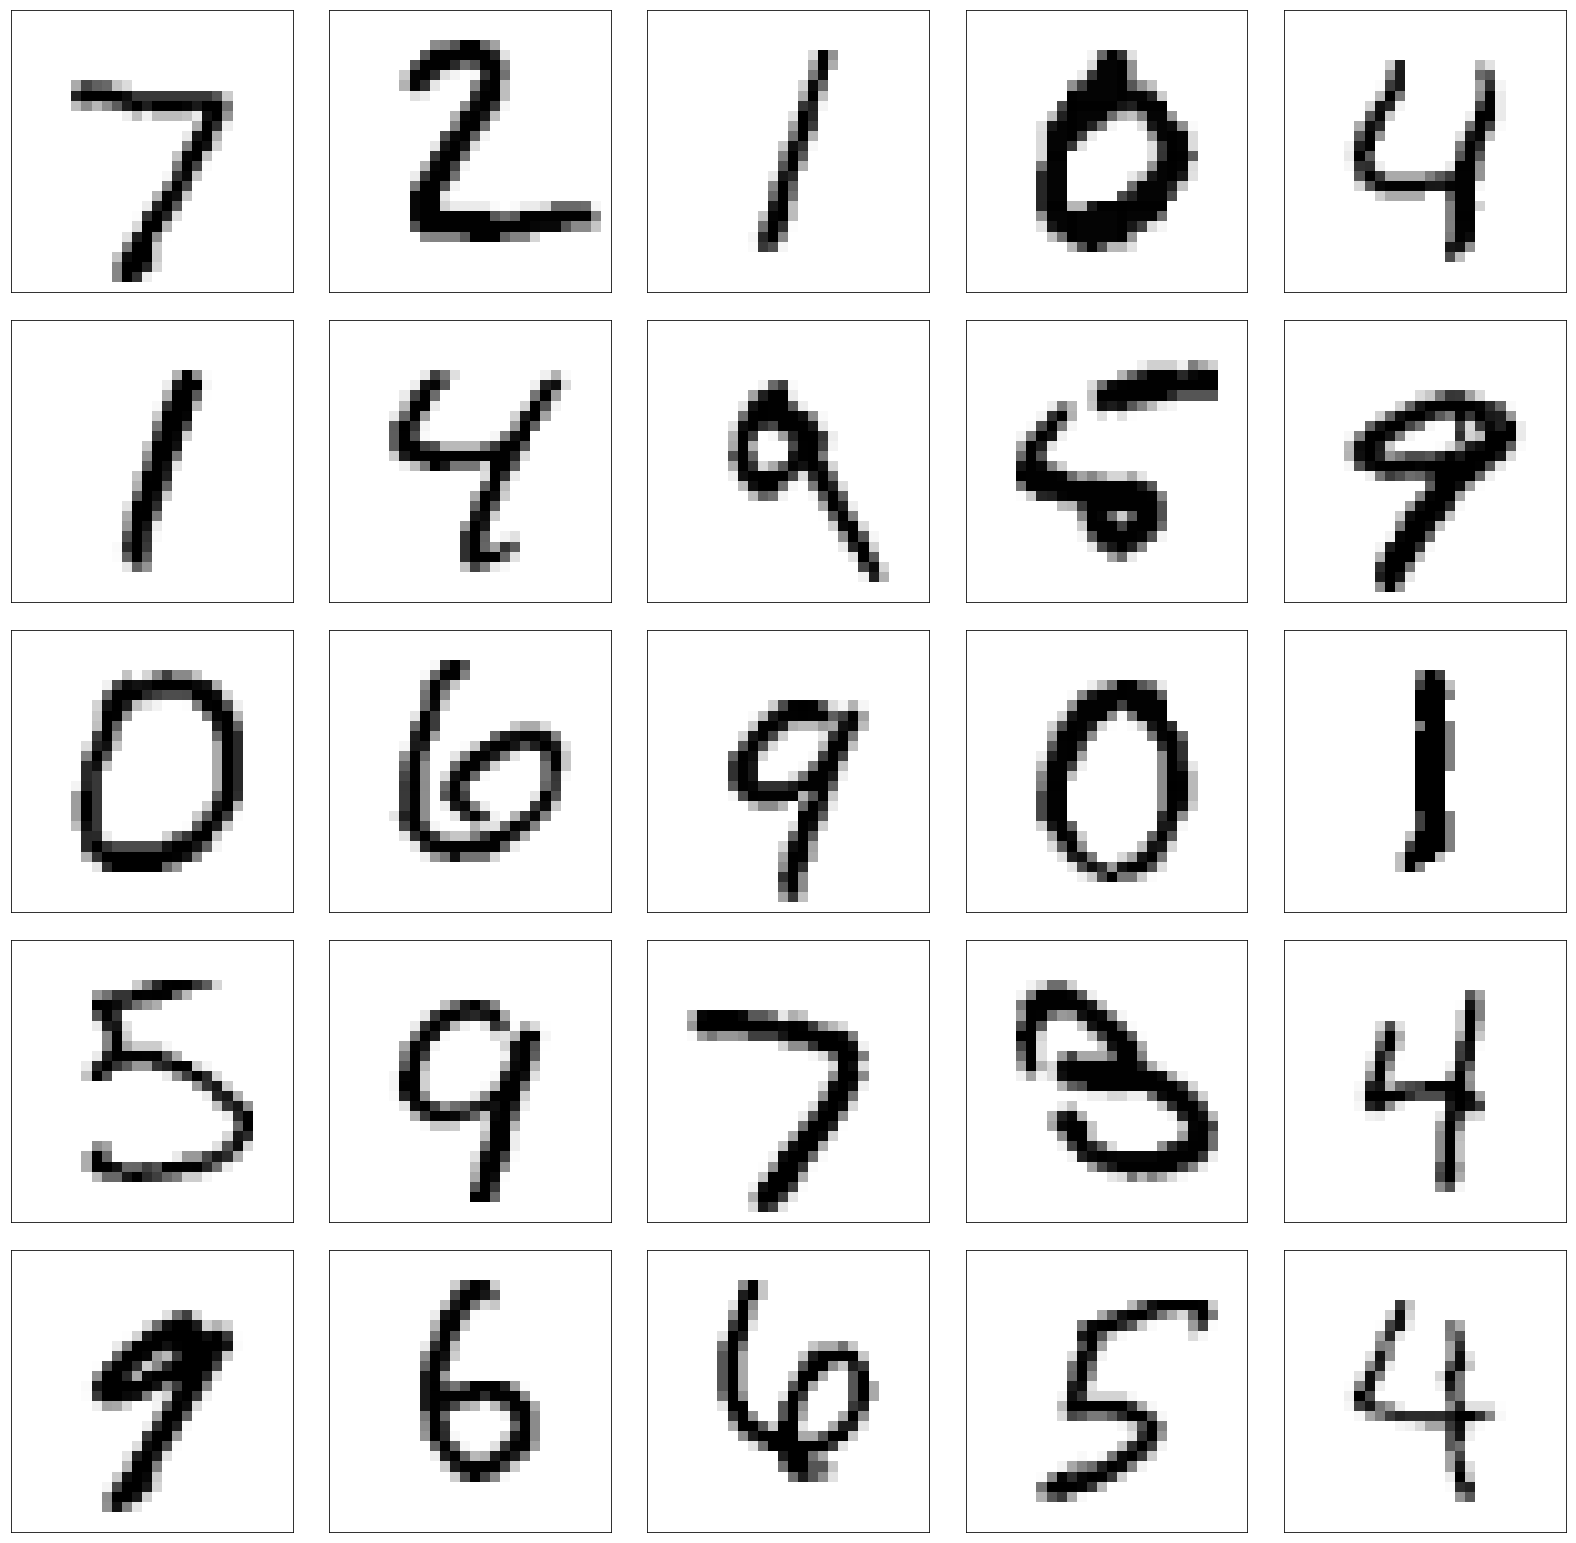

In [3]:
%matplotlib inline
from __future__ import division, print_function, absolute_import

import tensorflow as tf
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

x = tf.reshape(mnist.test.images, shape=[-1, 28, 28])

x1 = tf.Session().run(x)

import matplotlib.pyplot as plt
fix, axes = plt.subplots(5,5, figsize=(28,28),subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
        #ax.text(0.05,0.05, str(mnist.test.images[i]), transform=ax.transAxes, color='green')
        ax.imshow(x1[i], cmap='binary', interpolation='nearest')

In [4]:
import tensorflow as tf

In [38]:

from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf

# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit


# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training, conv1Arg, conv2Arg):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        param = {'input': x, }
        
        conv1 = tf.layers.conv2d(inputs=x, **conv1Arg)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(inputs=conv1, **conv2Arg)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode, params):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True, conv1Arg = params['conv1Arg'], conv2Arg = params['conv2Arg'])
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False, conv1Arg = params['conv1Arg'], conv2Arg = params['conv2Arg'])

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

def testSeries(args):

    results = []


    for param in args:
        model = tf.estimator.Estimator(model_fn, params = 
                               {
                                   'conv1Arg': param['conv1Arg'],
                                   'conv2Arg': param['conv2Arg']
                               })
        # Define the input function for training
        input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.train.images}, y=mnist.train.labels,
            batch_size=batch_size, num_epochs=None, shuffle=True)
        # Train the Model
        model.train(input_fn, steps=num_steps)

        # Evaluate the Model
        # Define the input function for evaluating
        input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': mnist.test.images}, y=mnist.test.labels,
            batch_size=batch_size, shuffle=False)
        # Use the Estimator 'evaluate' method
        e = model.evaluate(input_fn)
        print("Testing Accuracy:", e['accuracy'])
        results.append({'param':param, 'result': e})
    
    counter = 1
    for result in results:
        print(str(counter) + ') ' + str(result['param']) + ' - ' + str(result['result']['accuracy']) )
        counter = counter + 1


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [39]:
    params = [{'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.relu, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu, 'filters': 10},
           'conv2Arg': {'kernel_size':3, 'activation': tf.nn.relu, 'filters': 20} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu, 'filters': 50},
           'conv2Arg': {'kernel_size':3, 'activation': tf.nn.relu, 'filters': 100} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu, 'filters': 20},
           'conv2Arg': {'kernel_size':3, 'activation': tf.nn.relu, 'filters': 40} 
          }
         ]
testSeries(params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\samso\\AppData\\Local\\Temp\\tmpfcwrp5kt', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\samso\AppData\Local\Temp\tmpfcwrp5kt\model.ckpt.
INFO:tensorflow:loss = 2.33009, step = 1
INFO:tensorflow:global_step/sec: 15.0521
INFO:tensorflow:loss = 0.0877352, step = 101 (6.646 sec)
INFO:tensorflow:global_step/sec: 15.2045
INFO:tensorflow:loss = 0.024963, step = 201 (6.577 sec)
INFO:tensorflow:global_step/sec: 15.3563
INFO:tensorflow:loss = 0.0254864, step = 301 (6.512 sec)
INFO:tensorflow:global_step/sec: 14.2816
INFO:tensorflow:loss = 0.0353318, step = 401 (7.002 sec)
INFO:tensorflow:global_step/sec: 14.8456
INFO:tensorflow:loss = 0.0234501, 

INFO:tensorflow:loss = 0.00227917, step = 1601 (10.261 sec)
INFO:tensorflow:global_step/sec: 9.83671
INFO:tensorflow:loss = 0.00461255, step = 1701 (10.166 sec)
INFO:tensorflow:global_step/sec: 9.8174
INFO:tensorflow:loss = 0.0082155, step = 1801 (10.187 sec)
INFO:tensorflow:global_step/sec: 9.57578
INFO:tensorflow:loss = 0.00541128, step = 1901 (10.443 sec)
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\samso\AppData\Local\Temp\tmpgump1l2p\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00458944.
INFO:tensorflow:Starting evaluation at 2018-05-10-17:13:58
INFO:tensorflow:Restoring parameters from C:\Users\samso\AppData\Local\Temp\tmpgump1l2p\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-05-10-17:14:01
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.99, global_step = 2000, loss = 0.0316753
Testing Accuracy: 0.99
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\samso\\AppData\\Local\\Temp\\tmptofqhdv

In [40]:
params = [{'conv1Arg': {'kernel_size':5, 'activation': tf.nn.sigmoid, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.sigmoid, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.tanh, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.tanh, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.elu, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.elu, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.softplus, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.softplus, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.softsign, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.softsign, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.relu, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.relu6, 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.relu6, 'filters': 64} 
          },
          {'conv1Arg': {'kernel_size':5, 'activation': tf.nn.crelu , 'filters': 32},
           'conv2Arg':{'kernel_size':3, 'activation': tf.nn.crelu , 'filters': 64} 
          }
         ]

testSeries(params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\samso\\AppData\\Local\\Temp\\tmp_7c885no', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\samso\AppData\Local\Temp\tmp_7c885no\model.ckpt.
INFO:tensorflow:loss = 2.61314, step = 1
INFO:tensorflow:global_step/sec: 14.5603
INFO:tensorflow:loss = 2.26442, step = 101 (6.869 sec)
INFO:tensorflow:global_step/sec: 14.6327
INFO:tensorflow:loss = 2.01894, step = 201 (6.835 sec)
INFO:tensorflow:global_step/sec: 14.622
INFO:tensorflow:loss = 0.834612, step = 301 (6.839 sec)
INFO:tensorflow:global_step/sec: 14.5578
INFO:tensorflow:loss = 0.437588, step = 401 (6.868 sec)
INFO:tensorflow:global_step/sec: 14.245
INFO:tensorflow:loss = 0.355633, step = 5

INFO:tensorflow:global_step/sec: 14.6454
INFO:tensorflow:loss = 0.0133605, step = 1701 (6.828 sec)
INFO:tensorflow:global_step/sec: 14.6762
INFO:tensorflow:loss = 0.0254447, step = 1801 (6.834 sec)
INFO:tensorflow:global_step/sec: 14.7512
INFO:tensorflow:loss = 0.0302449, step = 1901 (6.760 sec)
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\samso\AppData\Local\Temp\tmph6t8dsbh\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0474636.
INFO:tensorflow:Starting evaluation at 2018-05-10-17:22:52
INFO:tensorflow:Restoring parameters from C:\Users\samso\AppData\Local\Temp\tmph6t8dsbh\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-05-10-17:22:55
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9833, global_step = 2000, loss = 0.0535802
Testing Accuracy: 0.9833
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\samso\\AppData\\Local\\Temp\\tmpowifrio8', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_

INFO:tensorflow:global_step/sec: 15.2435
INFO:tensorflow:loss = 0.0238688, step = 901 (6.560 sec)
INFO:tensorflow:global_step/sec: 15.2717
INFO:tensorflow:loss = 0.00728833, step = 1001 (6.549 sec)
INFO:tensorflow:global_step/sec: 15.1768
INFO:tensorflow:loss = 0.101733, step = 1101 (6.588 sec)
INFO:tensorflow:global_step/sec: 15.3116
INFO:tensorflow:loss = 0.0161321, step = 1201 (6.531 sec)
INFO:tensorflow:global_step/sec: 15.071
INFO:tensorflow:loss = 0.0278853, step = 1301 (6.635 sec)
INFO:tensorflow:global_step/sec: 15.1085
INFO:tensorflow:loss = 0.0104719, step = 1401 (6.620 sec)
INFO:tensorflow:global_step/sec: 15.2648
INFO:tensorflow:loss = 0.0305732, step = 1501 (6.551 sec)
INFO:tensorflow:global_step/sec: 15.0281
INFO:tensorflow:loss = 0.0166011, step = 1601 (6.653 sec)
INFO:tensorflow:global_step/sec: 14.7446
INFO:tensorflow:loss = 0.0149945, step = 1701 (6.782 sec)
INFO:tensorflow:global_step/sec: 14.8148
INFO:tensorflow:loss = 0.0127014, step = 1801 (6.763 sec)
INFO:tensorf